<a href="https://colab.research.google.com/github/MHadavand/Lessons/blob/master/ML/ANN/TensorFlowReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

TensorFlow™ is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices [1].

Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains.

TensorFlow is an interface to express machine learning algorithms and provides an implementation for executing such algorithms. In this regard, TensoFlow is not a package/API that can be used to pass your training data and get a predictor/classifier/regression tool. Instead, it is a lower level library that provides features required to implement machine learning algorithms in an optimal way. Also, there are predefined implementations of algorithms that a user can use if the flexibility of designing the implementation is not desired. 

TensorFlow is designed to facilitate scaling your application by separating the language interface and the execution allowing the code to be executed as a prototype on your laptop or the final product on a cluster.

*Language Interface:*

    Python, C++, ...

*Execution Environment:*

    Execution master to choose Local CPU, GPU or a master node on a cluster

Source of the name TensorFlow: N dimensional arrays aka Tensors along with mathematical operations are the base of the computation graph executed by TensorFlow.


**References:**

http://TensorFlow.org

https://app.pluralsight.com

# Installation

The following factors can affect the installation:
    - OS
    - GPU (cuda enabaled) 
    - Environment (Direct, Virtual, Docer Container)
    - Python version (assumin that python is used for the programming language)
        Linux, MacOS --> 2.7, 3.3 or later
        windows --> 3.5 or later
    
**For graphic cards info:**

```shell
$ dxdiag
```
or use chrome:gpu on your chrome browser

**For python version:**

```python
import sys
sys.version
```

**Installation using pip:**

```shell
pip install --upgrade tensorflow -- Chose the cpu version
```

Note that on tensorflow.org you have the option to download the source file from github and config it on your machine.



In [1]:
import sys
sys.version

## Testing installation

In [2]:
import warnings
warnings.filterwarnings("ignore") # Avoid some deprecation warnings
import tensorflow as tf
print('TensorFlow version {}'.format(tf.__version__))
print(tf.__doc__)

TensorFlow version 2.1.0
TensorFlow root package


In [3]:
a = tf.constant(20)
b = tf.constant(50)
print('a*b = {}'.format(a*b))

a*b = 1000


# First Example

A simple example of predictinh house proce based on as single variable/feature of house size.

In [4]:
import tensorflow.compat.v1 as tf # In order to use V1 of tensor flow using tesnorflow 2.*
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import math
import random
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rc
rc('animation', html='jshtml')
import os
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


## Data preparation

In [5]:
num_house = 200
np.random.seed(69067)
house_size = np.random.randint(1000, 3500, num_house)
data_housing = pd.DataFrame(columns=['HouseSize'], data=house_size)

data_housing['HousePrice'] = data_housing['HouseSize'].apply(lambda size: size* 200 + np.random.randint(10000, 60000))

In [6]:
data_housing.head()

,HouseSize,HousePrice
0,2888,603358
1,3004,645019
2,1020,245554
3,2062,446094
4,2518,544830


### Visualize data

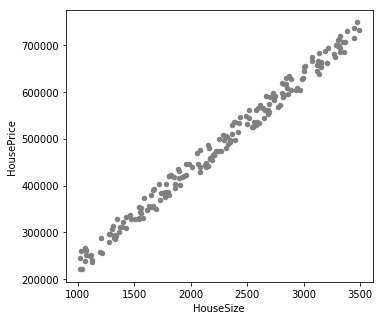

In [7]:
fig,ax = plt.subplots(1,1, figsize=(5.5,5))
# Simple scat plot
_ = data_housing.plot(x='HouseSize', y='HousePrice', kind='scatter',ax=ax, color='gray')

%%latext
The price was generated based on a simple equation:

$ Price = SizeFactor \times Size + PriceOffset $

### Standardization

In [8]:
size_mean = np.mean(data_housing['HouseSize'])
size_std = np.std(data_housing['HouseSize'])
data_housing['HouseSize_std'] = data_housing['HouseSize'].apply(lambda x: (x - size_mean)/ size_std )

price_mean = np.mean(data_housing['HousePrice'])
price_std = np.std(data_housing['HousePrice'])
data_housing['HousePrice_std'] = data_housing['HousePrice'].apply(lambda x: (x - price_mean)/ price_std)

data_housing.head()

,HouseSize,HousePrice,HouseSize_std,HousePrice_std
0,2888,603358,0.911765,0.834757
1,3004,645019,1.077531,1.128504
2,1020,245554,-1.757644,-1.688076
3,2062,446094,-0.268606,-0.274092
4,2518,544830,0.383027,0.422083


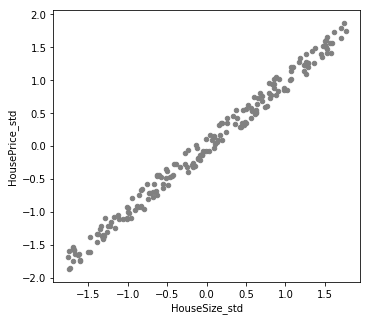

In [9]:
fig,ax = plt.subplots(1,1, figsize=(5.5,5))
# Simple scat plot
data_housing.plot(x='HouseSize_std', y='HousePrice_std', kind='scatter',ax=ax, color='gray')

### Select test and train data

In [10]:
tarin_portion = 0.7
train_mask = np.random.rand(len(data_housing)) < tarin_portion
data_housing_train = data_housing[train_mask].reset_index(drop=True)
num_tarining_data = len(data_housing_train)
data_housing_test = data_housing[~train_mask].reset_index(drop=True)
print('Number of training data: {} \nNumber of test data: {}'.format(len(data_housing_train), len(data_housing_test)))

Number of training data: 139 
Number of test data: 61


In [11]:
# Inspect training data
data_housing_train.head()

,HouseSize,HousePrice,HouseSize_std,HousePrice_std
0,2888,603358,0.911765,0.834757
1,3004,645019,1.077531,1.128504
2,1020,245554,-1.757644,-1.688076
3,2062,446094,-0.268606,-0.274092
4,2518,544830,0.383027,0.422083


## Use tensor flow
Note about tensor types:

- Constant: Constant value that does not change
- Variable: Value adjusted in the computation graph of TensorFlow
- PlaceHodler: Used to pass data into the graph (e.g. from an external source)

Also, the following concepts:
- Model: A set of mathematical operations supported by tensor flow that defined the neural network part of the computation graph
- Cost function: The target function to optimize by calculation the error and modify the weight through back propagation steps
- Optimization algorithm

In [12]:
# DEfine the placeholders that get updated as our model gets optimized
tf_house_size = tf.placeholder(dtype='float', name='HouseSize')
tf_house_price =tf.placeholder(dtype='float', name='HousePrice')

In [13]:
# Define variables that get modified as we train our model based on the provided data
tf_size_factor = tf.Variable(np.random.randn(), name = 'SizeFactor')
tf_price_offset = tf.Variable(np.random.randn(), name = 'PriceOffset')

In [14]:
# Define the operation/model that needs to be trained to provide optimal result (minimum error based on the training data)
tf_price_predict = tf.add(tf.multiply(tf_size_factor, tf_house_size), tf_price_offset)

In [15]:
# Define a cost fucntion that can be used to tarin the model i.e. mean squer error
tf_cost = tf.reduce_sum(tf.pow(tf.subtract(tf_price_predict,tf_house_price),2))/num_tarining_data

In [16]:
learning_rate = 0.1
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = optimizer.minimize(tf_cost)

In [17]:
init = tf.global_variables_initializer()
dispaly_freq = 5
num_train_iterations = 50

size_factor_calc = []
price_offset_calc = []
training_cost = []

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        # This works becuase of the reduce sum over all data
        sess.run(optimizer, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        
#         # Alternatively, each training record may be passed separately (TensorFlow optimizer remembers)
#         for (x,Y) in zip(data_housing_train['HouseSize_std'], data_housing_train['HousePrice_std']): # Note that palce holders need to be fed
#             sess.run(optimizer, feed_dict={tf_house_size: x, tf_house_price: Y})
        
        # Get the cost function value
        c = sess.run(tf_cost, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        training_cost.append(c)
        # get the size factor and price offset st the current iteration
        size_factor_calc.append(sess.run(tf_size_factor))
        price_offset_calc.append(sess.run(tf_price_offset))
        
        if (iteration + 1)%dispaly_freq == 0:
            
            
            print('Iteration number: %03d'%(iteration+1), 'cost = {:.9f}'.format(training_cost[iteration]),\
                 'size factor =', size_factor_calc[iteration], 'price offset=', price_offset_calc[iteration])
            
    print('Optimization is done!')
    print('Final training cost = {:.5f}'.format(training_cost[-1]))
    print('Final size factor = ', size_factor_calc[-1])
    print('Final price offset = ', price_offset_calc[-1])

Iteration number: 005 cost = 0.335674226 size factor = 0.48411888 price offset= 0.20984949
Iteration number: 010 cost = 0.041418154 size factor = 0.8385502 price offset= 0.059047006
Iteration number: 015 cost = 0.013540602 size factor = 0.9478251 price offset= 0.013060032
Iteration number: 020 cost = 0.010899332 size factor = 0.9815206 price offset= -0.0009520473
Iteration number: 025 cost = 0.010649065 size factor = 0.9919124 price offset= -0.0052176025
Iteration number: 030 cost = 0.010625349 size factor = 0.99511784 price offset= -0.0065148068
Iteration number: 035 cost = 0.010623102 size factor = 0.9961068 price offset= -0.0069088666
Iteration number: 040 cost = 0.010622889 size factor = 0.99641186 price offset= -0.007028422
Iteration number: 045 cost = 0.010622868 size factor = 0.9965061 price offset= -0.0070646424
Iteration number: 050 cost = 0.010622867 size factor = 0.9965352 price offset= -0.007075592
Optimization is done!
Final training cost = 0.01062
Final size factor =  0.9

### Visualize gradient descent evolution

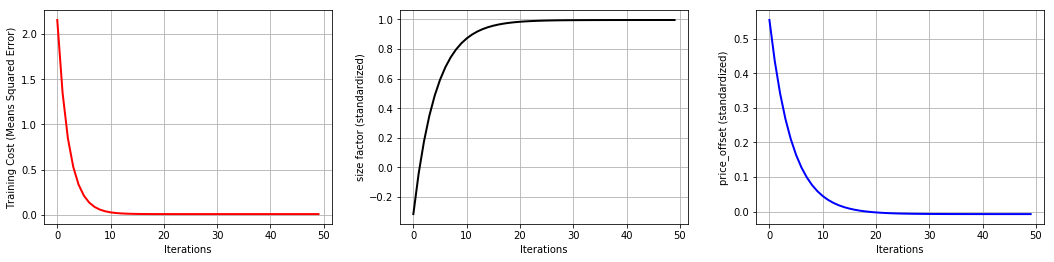

In [18]:
fig, minax = plt.subplots(1,3,figsize=(15,4))

ax = minax[0]
ax.plot(training_cost, c = 'r', lw =2)
ax.set_xlabel('Iterations'); ax.set_ylabel('Training Cost (Means Squared Error)')
ax.grid(True)

ax = minax[1]
ax.plot(size_factor_calc, c='k', lw=2)
ax.set_xlabel('Iterations'); ax.set_ylabel('size factor (standardized)')
ax.grid(True)

ax = minax[2]
ax.plot(price_offset_calc, c='b', lw=2)
ax.set_xlabel('Iterations'); ax.set_ylabel('price_offset (standardized)')
ax.grid(True)

fig.tight_layout(pad = 2.0)

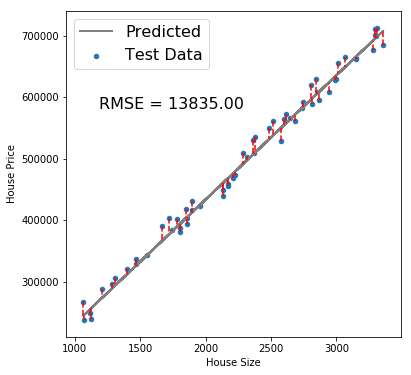

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

test_price_predicted = (size_factor_calc[-1]*data_housing_test.HouseSize_std + price_offset_calc[-1]) * price_std + price_mean

# Predicted Model
ax.plot(data_housing_test.HouseSize, test_price_predicted, c='gray', lw=2, label = 'Predicted')
# Actual test data
ax.scatter(data_housing_test.HouseSize, data_housing_test.HousePrice, s = 20, label = 'Test Data')

mean_squared_error = 0
for price_point, size_point, price_pred in zip(data_housing_test.HousePrice, data_housing_test.HouseSize, test_price_predicted):
    ax.plot([size_point, size_point], [price_point, price_pred], c='r', lw=1.5, ls ='--')
    mean_squared_error += (price_point - price_pred)**2

mean_squared_error = mean_squared_error/len(data_housing_test)
rmse = np.sqrt(mean_squared_error)

ax.text(0.1,.7, 'RMSE = {:.2f}'.format(rmse), transform = ax.transAxes, fontsize=16)

ax.set_xlabel('House Size'); ax.set_ylabel('House Price')
ax.legend(fontsize = 16)

## Comparison with Linear Regression

This example can be also solved by simple linear regression. As shown below, the result of gradient descent optimization and regression analysis are very close.

In [20]:
X = data_housing_test.HouseSize
y = data_housing_test.HousePrice
slope = np.cov(X,y)[0][1]/np.cov(X,y)[0][0] # Covariance(X,y)/Variance(X)
intercept = np.mean(y)-slope*np.mean(X) # mean(y) - slope * mean(X)

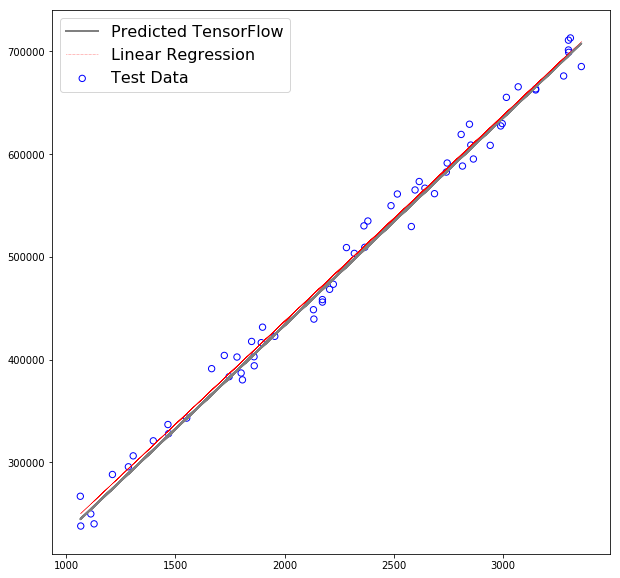

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# Predicted Model (TensorFlow)
ax.plot(data_housing_test.HouseSize, test_price_predicted, c='gray', lw=2, label = 'Predicted TensorFlow')
# Actual test data
ax.scatter(data_housing_test.HouseSize, data_housing_test.HousePrice, s = 40, label = 'Test Data', facecolors='none', edgecolors='b')
# Predicted linear regression
ax.plot(data_housing_test.HouseSize, slope*data_housing_test.HouseSize+intercept, c='red', lw=0.5, linestyle=':', label = 'Linear Regression')
ax.legend(fontsize = 16)

The root mean squared error of the optimized model for test data is shown in the plot above along with deviations of the actual price from the predicted one using the simple linear model. This is a simple linear regression example that was implemented using TensorFlow. Note that while variables rely on the initialization, placeholders are the tensors provided based on data (i.e. external source compared to the computation graph). You need to make sure the provided data result in tensors with dimensions that comply with the operation that you have added to your model.

# Tensor

Some introduction to tensor properties help to better understand how TensorFlow works. Note that mathematics is the base of any algorithm developed by humans. In case of tensors, linear algebra/multilinear algebra is of great significance.

Tensor may be defined as an n-dimensional array to represent data. For example 500 observations of 4 variable may be a tensor of 4 by 500 or the other way around.

## Tensor Properties

Tensors in an operation need to shared compatible properties. 

### Rank

Dimensionality of a tensor.

| Rank        | Object           |
| ------------- |:-------------:|
| 0      | scalar |
| 1      | vector      |
| 2 | N by N matrix   |
| 3 | 3-Tensor(cube)   |
| n | n-Tensor(cube)   |

### Shape

It is closely related to the rank and also number of data in the tensor

example: 

| Rank        | Object           |  Example | Shape
| ------------- |:-------------:|:-------------:| :-------------:| 
| 0 |Scalar|s = 25 | []| 
| 2 |Matrix|m = [[1,2,3], [4,5,6]] | [2,3]| 
 
### Data Type

The following data types are supported by TensorFlow

- float32, float64
- int8, int16, int32, int64
- uint8, uint16
- string
- bool
- complex64, complex128
- qint8, qint16

qint short for Quantized values. The quantized data type is used to scale data/number to reduce size so it takes less bits. This helps to improve processing power of TensorFlow which is critical for scalability. Google has invested on special processing chips called TensoFlow Processing Units (TPUs) that utilize quantized values. 


### Tensor Info

TensorFlow provides the following methods to inspect a tensor:

- get_shape 
- reshape
- rank
- dtype
- cast

# Gradient Descent

Gradient descent is a popular optimization algorithm that works based on finding sequential steps/vectors in the multivariate space of features that provide the steepest reduction in the loss/cost function or steepest increase in the profit/gain function. The learning rate corresponds to the length of the vectors. The direction is determined based on derivative based on the features. 

![Gradient Descent](https://github.com/MHadavand/Lessons/blob/master/ML/Figures/GradientDescent.png?raw=true "Obtained from https://www.oreilly.com/")

## Animate Gradient Descent 

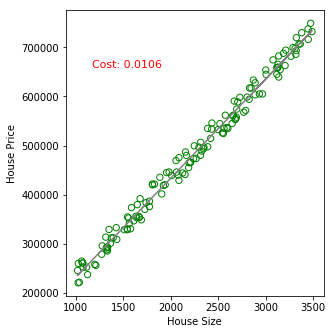

In [22]:
init = tf.global_variables_initializer()
dispaly_freq = 5
num_train_iterations = 50
%matplotlib inline

with tf.Session() as sess:
    sess.run(init)
    
    size_factor_calc = []
    price_offset_calc = []
    training_cost = []
    
    
    for iteration in range(num_train_iterations):
        
        # This works becuase of the reduce sum over all data
        sess.run(optimizer, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        
        # Get the cost function value
        c = sess.run(tf_cost, feed_dict={tf_house_size: data_housing_train['HouseSize_std'],
                                             tf_house_price: data_housing_train['HousePrice_std']})
        training_cost.append(c)
        # get the size factor and price offset st the current iteration
        size_factor_calc.append(sess.run(tf_size_factor))
        price_offset_calc.append(sess.run(tf_price_offset))

    
    fig, ax = plt.subplots(1,1,figsize=(5,5))

    
    # Actual tarining data
    ax.scatter(data_housing_train.HouseSize, data_housing_train.HousePrice, s = 40, facecolors='none', edgecolors='g', label = 'Test Data')
    ax.set_xlabel('House Size')
    ax.set_ylabel('House Price')
    
    line, = ax.plot([],[], c='gray') 
    time_text = ax.text(.1, .8, '', fontsize=11, transform = ax.transAxes, color='r')
    fig.tight_layout(pad = 2.0)
    
    def update(i):
        test_price_predicted = (size_factor_calc[i]*data_housing_train.HouseSize_std + price_offset_calc[i]) * price_std + price_mean
        line.set_xdata(data_housing_train.HouseSize)
        line.set_ydata(test_price_predicted)
        time_text.set_text('Cost: {:.4f}'.format(training_cost[i]))
        return line, time_text,
    
    
    def initAnim():
        test_price_predicted = (size_factor_calc[0]*data_housing_train.HouseSize_std + price_offset_calc[0]) * price_std + price_mean
        line.set_ydata(test_price_predicted)
        line.set_xdata(data_housing_train.HouseSize)
        return line,
    
    anim = animation.FuncAnimation(fig, update, frames=num_train_iterations, init_func=initAnim, interval=200, blit=True)
    anim.save('animation.gif',writer='pillow', fps=30)
anim

# MNIST example

A data set containing 28 by 28 images of handwritten numbers from 0 to 9.

## Simple Neural Network

A simple network with one layer that maps the image pixels into the output classification categories (i.e. classes).

In [23]:
import random
import numpy as np

### Helper Functions

In [24]:
from matplotlib import pyplot as plt
from matplotlib import animation
from tensorflow import keras
import numpy as np

def image_plot(image, digit, cmap='bone_r', figsize=(5,5)):

    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.text(0.1,0.85,'Label : {}'.format(digit), fontsize=15, color ='b', transform=ax.transAxes)
    _ = ax.imshow(image, cmap='bone_r')

def transform_label(x):
    ''' Using the one hot concept to model the 9 discrete possible integer values for classification to get
        probability of each class. Using argmax function allows us to get the correct class i.e. 0, 1, 2, ... 9
    '''
    one_hot = []
    for item in x:
        one_hot.append([float(int(i==item)) for i in range(0,10)])
    return np.array(one_hot)

def flatten_images(image):
    '''
    Flatten the image
    '''
    original_shape = image.shape # (number_images by y_pixels(rows) by x_pixels(columns))
    return image.reshape(original_shape[0], original_shape[1]*original_shape[1])

def mnist_weight_check(weight_tensor, figsize=(20,4), shape=[28,28], cmap='jet'):

    fig, mainax = plt.subplots(2,5,figsize=figsize)
    for i, ax in enumerate(mainax.flatten()):
        _ = ax.imshow(weight_tensor[:,i].reshape(shape[0],shape[1]), cmap=cmap)

def mnist_result_anim(images, digits_true, digits_predicted, shape=[28,28], cmap='bone_r', interval=500, repeat=True, n_iterations = None, video_file=None):

    try:
        _ = digits_true.shape[1]
    except:
        digits_true = transform_label(digits_true)

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    image = ax.imshow(np.zeros([28,28]), cmap=cmap)
    true_digit = ax.text(0.1, 0.9, s='True Value:', fontsize=12, transform = ax.transAxes, color='b')
    predicted_digit = ax.text(0.1, 0.85, s='PredictedValue:', fontsize=12, transform = ax.transAxes, color='g')

    def update(i):
        image=ax.imshow(images[i].reshape(shape[0],shape[1]),cmap=cmap)
        true_digit.set_text('True Value: {}'.format(np.argmax(digits_true[i])))
        predicted_digit.set_text('PredictedValue: {}'.format(np.argmax(digits_predicted[i])))
        color = '{}'.format('g' if np.argmax(digits_true[i]) == np.argmax(digits_predicted[i]) else 'r')
        predicted_digit.set_color(color)
        return image, true_digit, predicted_digit,
    if n_iterations is None:
        n_iterations = len(images)
    anim = animation.FuncAnimation(fig, update, frames=n_iterations, interval=interval, blit=True, repeat=repeat)
    if video_file is not None:
        anim.save('{video_file}.gif'.format(video_file=video_file),writer='pillow', fps=30)
    return anim

def conv_result_anim(images, conv1, conv2, conv1_tf, conv2_tf, shape=[28,28], cmap='bone_r'):

    fig, ax = plt.subplots(1,3,figsize=(12,4))
    image1 = ax[0].imshow(images[0].reshape(shape[0],shape[1]), cmap=cmap)
    ax[0].set_title('Input Image')

    image2 = ax[1].imshow(conv1[0][:,:,np.random.randint(0,conv1_tf.shape[-1].value)].reshape(conv1_tf.shape[1].value,conv1_tf.shape[2].value), cmap=cmap)
    ax[1].set_title('Convolution Layer 1')

    image3 = ax[2].imshow(conv2[0][:,:,np.random.randint(0,conv2_tf.shape[-1].value)].reshape(conv2_tf.shape[1].value,conv2_tf.shape[2].value), cmap=cmap)

    ax[2].set_title('Convolution Layer 2')

    def update(i):
            image1 = ax[0].imshow(images[i].reshape(shape[0],shape[1]), cmap=cmap)

            image2 = ax[1].imshow(conv1[i][:,:,np.random.randint(0,conv1_tf.shape[-1].value)].reshape(conv1_tf.shape[1].value,conv1_tf.shape[2].value), cmap=cmap)

            image3 = ax[2].imshow(conv2[i][:,:,np.random.randint(0,conv2_tf.shape[-1].value)].reshape(conv2_tf.shape[1].value,conv2_tf.shape[2].value), cmap=cmap)

            return image1, image2, image3
    plt.tight_layout()

    return animation.FuncAnimation(fig, update, frames=len(images), interval=450, blit=True, repeat=True)

The input data from TensorFlow's tutorial was not used as it has a deprecation warning. Instead, keras datasets was used to get the mnist data set. The main difference is that the image is not flatten and the labels are not classified by an array with max probability i.e. one_hot.

In [25]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Check an example image from the training set

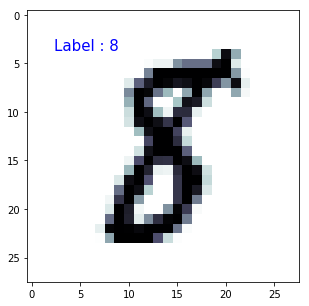

In [26]:
%matplotlib inline
image_plot(x_train[125], y_train[125])

### Transformations

In [27]:
y_train, y_test = transform_label(y_train), transform_label(y_test)

In [28]:
x_train, x_test = flatten_images(x_train), flatten_images(x_test)

### Define the model

In [29]:
# plcae holder for the input which is a 28 by 28 image data
x = tf.placeholder(tf.float32, shape=[None,784])
#place holder for predcicted output
y = tf.placeholder(tf.float32, shape=[None,10])

# Weights and bias for the only layer of the model
w = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

layer1=tf.matmul(x,w)+b

# Define model (make sure that the tensor rank an shape comply with the operation)
y_p = tf.nn.softmax(layer1) # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)

# Define the lost that is cross_entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=layer1))
# Note: soft max is implmeneted so logits should be layer1 although using y_p would work too

learning_rate = 0.5
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

### Define the performance measure

In [30]:
correct = tf.equal(tf.argmax(y_p,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### Run the model

Note that the initial guess (i.e. zeros or random normal) can significantly affect the performance of the model and depending on the type of optimization algorithm, it may get the model trapped in local optimal solutions for weights and biases.

In [31]:
batch_size = 200
batch_list = [ i for i in range(0,len(x_train),batch_size)] # Break training data into batches
nump_epoch = 20
weight_repo = [] # Get all the weights

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # Session initilization
    
    for epoch in range(nump_epoch):
        for i in range(len(batch_list)-1):
            start_index = batch_list[i]
            end_index = batch_list[i+1]
            x_batch = x_train[start_index:end_index]
            y_batch = y_train[start_index:end_index]
            sess.run(optimizer, feed_dict={x: x_batch, y: y_batch})

        cost = sess.run(cross_entropy, feed_dict={x: x_batch, y:y_batch})
        
        accuracy_train = sess.run(accuracy, feed_dict={x: x_train, y:y_train})*100
        accuracy_test = sess.run(accuracy, feed_dict={x: x_test, y:y_test})*100
        print('Epoch: {}, Accuracy_train: %{:.2f}, Accuracy_test: %{:.2f}, Cost: {:.3f}'.format(epoch+1,
                                                                                                accuracy_train,
                                                                                                accuracy_test,
                                                                                                cost),end='')
        print('\r', end='')
        weight_repo.append(sess.run(w, feed_dict={x: x_batch, y:y_batch}))
    
    prediction = sess.run(y_p, feed_dict = {x: x_test, y: y_test})

### Visualize the final weights

Note that weights that connect all the pixels into one output neuron corresponds to the class that the neuron represents. As can be seen below, the first neuron that classifies zero, assigns more weights to the pixels that form the number 0 and so on.

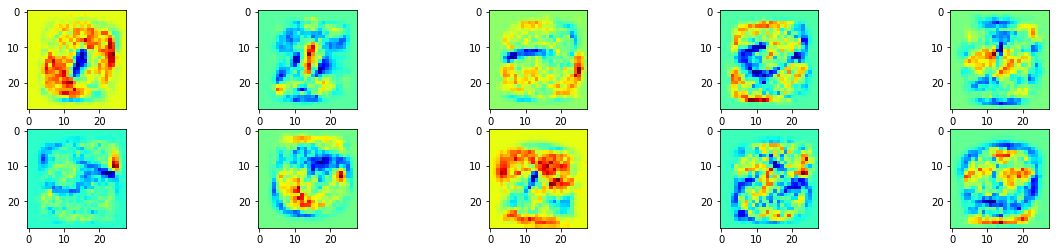

In [32]:
mnist_weight_check(weight_repo[-1], shape=[28,28], cmap='jet')

### Visualize the prediction 

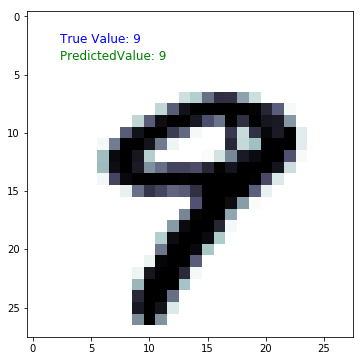

In [34]:
mnist_result_anim(x_test[0:10], y_test[0:10], prediction[0:10], video_file='mnist')

## Convolutional Network

Using convolution layer allows us to capture spatial features of the image through a moving averaging window using a random filter. As a result, one input image of a digit will be transformed to multiple possible convoluted images that helps to cover have a more generalized set of images for that digit and in turn helps to avoid over fitting.

In [35]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = transform_label(y_train), transform_label(y_test)
x_train, x_test = flatten_images(x_train), flatten_images(x_test)

### Settings

In [36]:
image_nrows = 28
image_ncolumns = 28
image_flat_size = image_nrows*image_ncolumns
n_channels = 1 # Gray scale
n_classes = 10 # 0,1,... 9

log_path = r'./tensorboard_log/' # Log path for tensor board
try:
    os.rmdir(log_path)
except:
    pass

### Define a summary helper function

In [37]:
def variable_summary(var):
    with tf.name_scope('Summary'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('Mean', mean)
        std = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('Std', std)
        
        tf.summary.scalar('Min', tf.reduce_min(var))
        tf.summary.scalar('Max', tf.reduce_max(var))
        tf.summary.histogram('HistoGram', var)

### Define the place holders

In [38]:
with tf.name_scope(name = 'InputLayer'):
    x = tf.placeholder(tf.float32, shape=[None, image_flat_size], name='Images')
    y = tf.placeholder(tf.float32, shape=[None,n_classes], name = 'Classes')

with tf.name_scope(name='ArgmaxTransform'):
    y_class = tf.argmax(y, axis=1, name='InputDigit') # One_Hot: The index with highest probabality

with tf.name_scope(name='ReshapeTransform'):
    # Get the image back into 28 by 28 pixels which can be used by the convolution layer
    x_image = tf.reshape(x, [-1,image_nrows,image_ncolumns,n_channels], name='Image_2D') # -1 is used to change a list of 1D arrays to a list of 2D images
    tf.summary.image('InputImage', x_image, 5)

Note that an image is defined by a 3D tensor in general: \{n_height(number of rows), n_width(number of columns), n_channels\}. A gray scale image has only 1 channel. Considering the number of images, the NHWC format can be used to have a rank 4 tensor for the input batch of images.

\{batch, in_height, in_width, in_channels\] = \[-1, 28, 28, 1\} ==> NHWC format 

Note: -1 is use as we do not know the batch number before hand.

### Defining initializer functions 

In [39]:
def sample_weights(shape, name=None):
    '''
    This function is used to get the filters that are used as the convolution filters.
    '''
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), name=name) # sample withing +-2 standard deviation from the mean that corresponds to 95% of the distribution 

def get_bias(shape, name=None):
    ''' 
    Constant biases added to each convolutional filter
    '''
    return tf.Variable(tf.constant(0.001, shape=shape), name=name)

The convolution of f and g is written f∗g. It is defined as the integral/summation of the product of the two functions after one is reversed and shifted.

$$
f * g (t) = \int f(\tau)g(t-\tau) \, d\tau
$$

### Function to define the convolution layer

Although the TensorFlow API/package makes it much easier to design the convolutional layer, there are a couple if steps that should be wrapped in a function to avoid repeatability and minimize changes to the code (try to align with solid design principles).

In [40]:
def new_convolutional_layer(input_tensor, # The output of the previous layer (e.g. training images for the first conv layer)
                            number_input_channels, # number of channels from the previous channel
                            filter_size, # size of the averaging window (squared one for this example)
                            number_filters, # Number of alternative filters
                            pooling = True, # Option to apply a pooling step after the convolution
                           ):
    
    '''
    A wrapper function to summarize cretaing a new convolutional layer using tensor flow.
    Input: Image based on NHWC format
    Output: NHWC format
            number of images: same as input
            height/row number: depending on the pooling window size (e.g. if 2 by 2, then devided by two)
            width/column number: Ditto
            Channels: Number of filters 
    Note that: In image processing, the point of using convolution is to apply a filter to the image using a mask/kernel. This
    can be used to blur the image or sharpen the edges and so on depending on the kernel matrix definition. The goal of applying 
    convolution layer is to get alternative represnetation of the same image using random filters that get optimized by the NN.
    '''
    
    # shape of the filter defined for TensoFlow's API
    filter_shape = [filter_size, filter_size, number_input_channels, number_filters]
    
    with tf.name_scope('Weights'):
        conv_weights = sample_weights(filter_shape, name='ConvolutionFilterWeights') # Sample a truncated normal distribution to get filters for an image/convluted image
        variable_summary(conv_weights)
        # Note that even the convolutional filter will be optimized by learnig from the training images
    with tf.name_scope('Biases'):
        biases = get_bias([number_filters], name='ConvolutionBias')
        variable_summary(biases)

    # Note that the combination of filter size, strides and padding determines the output tensor/image size
    layer = tf.nn.conv2d(input_tensor, # tensor matching the data_format provided
                         filter = conv_weights, # The convloutional filter
                         strides=[1,1,1,1], # the first and last one must be one to step over image and channel, second and third one are used to move the window
                         padding='SAME', # Padding takes care of matching the window and input tensor shape (corners)  
                         data_format='NHWC',
                         name = 'Convolution2D'
                        )
    # The same initilized bias is added to each channel of the result of the convolution
    layer += biases
    
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1,2,2,1], # Determines the size of the output 
                               strides=[1,2,2,1],# strides fo moving the pooling window
                               padding='SAME', # Account for corners
                               name='Pool2by2'
                              )
        
        
    # Using relu function (*Computes rectified linear: max(features, 0)*)
    # A filter to truncate nagative values
    layer = tf.nn.relu(layer)
    
    # Note that applying relu function is usually before pooling but for the max pool is does not matter (relu(max_pool(x)) = max_pool(relu(x)))
    # By applying relu after pooling, we can improve the performance ny reducing number of relu filters
    
    return layer, conv_weights

### Function to flatten the convoluted results

The result of the convolution layer is a rank 4 tensor. The fully connected layer requires to flatten the convoluted tensor to a rank 2 tensor (i.e. num_tensor/images by flattened tensor and channels)

In [41]:
def make_flat(layer, name=None):
    
    layer_shape = layer.get_shape()
    num_items =  layer_shape[0]
    num_features = np.array(layer_shape[1:], dtype=int).prod()
    
    return tf.reshape(layer, [-1,num_features], name=name), num_features # Reshape to num_items by num_features

### Output layer

In [42]:
def new_fc_layer(input_tensor, # NHWC
                   num_inputs,
                   num_outputs,
                   use_relu=True
                  ):
    ''' Provides the fully connected layer'''
    
    weights = sample_weights([num_inputs,num_outputs], name='FullConnectedWeights')
    
    biases = get_bias([num_outputs], name = 'FullConnectedBias')
    
    layer = tf.matmul(input_tensor, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

### Define the final model

In [43]:
filter_size1 = 5 # Squared filter
filter_size2 = 2

number_filters1 = 15 # Creating multiple alternatives for the filter to create differen convolutional alternative
number_filters2 = 20

In [44]:
with tf.name_scope(name='ConvLayer1'):
    conv_layer_1, conv_weights_1 = new_convolutional_layer(input_tensor=x_image, # [-1,28,28,1]
                                                           number_input_channels= n_channels, 
                                                           filter_size=filter_size1, # Size of the averaging window 
                                                           number_filters=number_filters1,
                                                           pooling=True)
conv_layer_1

<tf.Tensor 'ConvLayer1/Relu:0' shape=(?, 14, 14, 15) dtype=float32>

In [45]:
with tf.name_scope(name='ConvLayer2'):
    conv_layer_2, conv_weights_2 = new_convolutional_layer(input_tensor=conv_layer_1, # [-1,28/2,28/2,number_filters1] devided by 2 because of the pooling strides and ksize
                                                           number_input_channels= number_filters1, 
                                                           filter_size=filter_size2, # Size of the averaging window 
                                                           number_filters=number_filters2,
                                                           pooling=True)
conv_layer_2

<tf.Tensor 'ConvLayer2/Relu:0' shape=(?, 7, 7, 20) dtype=float32>

In [46]:
flat_layer, num_features = make_flat(conv_layer_2, name='FlatTransform')
flat_layer, num_features

(<tf.Tensor 'FlatTransform:0' shape=(?, 980) dtype=float32>, 980)

In [47]:
with tf.name_scope(name='FcLayer1'):
    layer_fc1= new_fc_layer(flat_layer, num_inputs=num_features, num_outputs=128, use_relu=True)# apply activation
layer_fc1

<tf.Tensor 'FcLayer1/Relu:0' shape=(?, 128) dtype=float32>

In [48]:
with tf.name_scope(name='FcLayer2'):
    layer_fc2 = new_fc_layer(layer_fc1, num_inputs=128, num_outputs=n_classes, use_relu=False) # Leave the activation
layer_fc2

<tf.Tensor 'FcLayer2/add:0' shape=(?, 10) dtype=float32>

#### The predicted layer

Applying the proper activation for prediction layer. The 10 classes are identified based on identifying the output neuron with highest probability/likelihood. In this context, it is required to normalize the results of the final layer for classification to be between 0 and 1 and with summation to be equal to one. This can be done by TensorFlow's softmax activation function

In [49]:
with tf.name_scope('Output'):
    y_p = tf.nn.softmax(layer_fc2, name='PredictedClasses')
    
with tf.name_scope(name='ArgmaxTransform'):
    y_p_class = tf.argmax(y_p, axis=1, name='PredictedDigit')

#### Define the cost

The best answer that matches the true label has the correct neuron with highest normalized entropy after applying softmax function. Also, the entropy needs to be minimized meaning that the answer is more certain and the right neuron has the maximum probability that is as close as possible to 1. This can be implemented using  

In [50]:
# Softmax is implemenetd in this function so we use layer_fc2for logits instead of y_p
with tf.name_scope('CrossEntropy'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels= y, logits=layer_fc2))
tf.summary.scalar('Cost', cost)

<tf.Tensor 'Cost:0' shape=() dtype=string>

In [51]:
with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

### Accuracy measure

In [52]:
with tf.name_scope(name='Accuracy'):
    correct_prediction = tf.equal(y_p_class,y_class)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('Accuracy', accuracy)

<tf.Tensor 'Accuracy_1:0' shape=() dtype=string>

### Run the model

In [53]:
batch_size = 200
batch_list = [ i for i in range(0,len(x_train),batch_size)] # Break training data into batches
nump_epoch = 15

all_summary = tf.summary.merge_all()

sess= tf.Session()
tb_writer = tf.summary.FileWriter(logdir = log_path, graph=sess.graph, session=sess)
sess.run(tf.global_variables_initializer())


for epoch in range(nump_epoch):
    for i in range(len(batch_list)-1):
        start_index = batch_list[i]
        end_index = batch_list[i+1]
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        _, summary = sess.run([optimizer, all_summary], feed_dict={x: x_batch, y: y_batch})  
        
    accuracy_val = sess.run(accuracy, feed_dict={x: x_test, y:y_test})*100
    print('Epoch: {}, Accuracy: %{:.2f}'.format(epoch+1, accuracy_val), end='')
    print('\r', end='')
    tb_writer.add_summary(summary, epoch)

In [54]:
# get the predictions for test data
prediction = sess.run(y_p, feed_dict = {x: x_test, y: y_test})

# get the final convolution image for layer 1
conv_1 = conv_layer_1.eval(feed_dict = {x: x_test, y: y_test}, session=sess)
conv_weight_1 = conv_weights_1.eval(session=sess)

# get the final convolution image for layer 2
conv_2 = conv_layer_2.eval(feed_dict = {x: x_test, y: y_test}, session=sess)
conv_weight_2 = conv_weights_2.eval(session=sess)

#save the result
import pickle
with open('ConvResults.pickle', 'wb') as handle:
    pickle.dump([prediction, conv_1, conv_2, conv_weight_1, conv_weight_2], handle, protocol=pickle.HIGHEST_PROTOCOL)

sess.close()

### Visualizations

#### Convolution layers
The animation below, shows the result of applying convolution filters on the image. It is recommended to use visualizations to understand how the convolution is implemented in TensorFlow. I think there is a shift/drift issue with the way that convolution is implemented because the filter is placed in a way that the target pixel is on the corner of the filter and not the center of the filter. Depending on the type of padding that can result in reduced number of pixels (padding='SAME' keeps the same pixel number). Also, using strides more than 1 for the row and column shift can distort the image. 

I think for more complicated image recognition problems, it is better to implement some pre-processing for the image using the known convolution filters (no need for optimization).

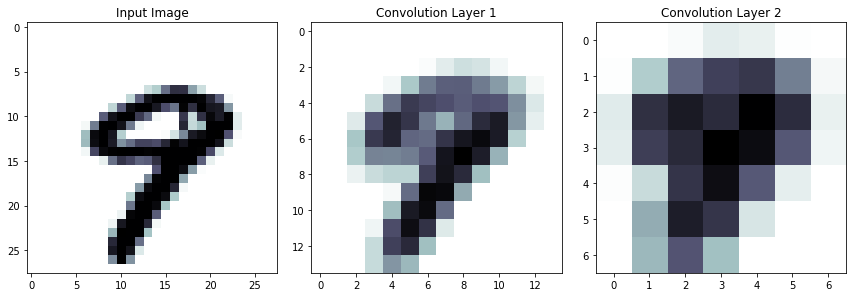

In [55]:
conv_result_anim(x_test[0:10], conv_1[0:10], conv_2[0:10], conv_layer_1[0:10], conv_layer_2[0:10], shape=[28,28])

#### Prediction vs True

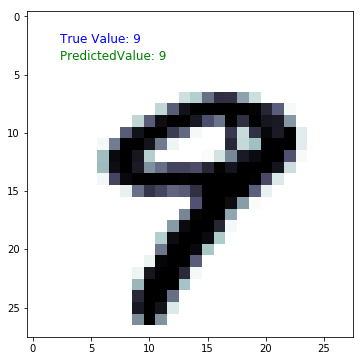

In [56]:
mnist_result_anim(x_test[0:10],y_test[0:10], prediction, interval=50)

## Inception

A strong tool/model developed by google for image classification with average performance better than human. The code is open source and part of tensor flow distribution. 

Training the model from scratch takes a lot of time and resources. However, the idea of transfer learning can be used to borrow/inherit the classification of model being trained and expand on that or use it for similar classification problems.

The main steps:
    - Get your data (i.e. flower images to classify)
    - Modify the inception model's last layer to correspond to the number of classes you need
    - Retrain the next to the last (bottleneck) layer with your own data. The layers before the bottle neck layer are used to extract image features and improve classification power of the bottleneck layer

## Using keras
 
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. For more information, visit Keras.io. Currently, keras is a part of TensorFlow distribution so no need to install it separately.

### Single Layer (Linear Regression)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the NN for doing Linear Regression
model = Sequential()

# Using Dense as the simplest layer. We use one Neuron becuase we just need the slope (one weight) plus intercept (one bias)
# The activation is lenear becuase we are doing linear regression
model.add(Dense(1, input_shape=(1,), activation='linear'))

model.compile(loss='mean_squared_error', optimizer='sgd') # Loss and optimizer (stochastic gradient descent)

#   Fit/train the model
model.fit(data_housing_train['HouseSize_std'], data_housing_train['HousePrice_std'], epochs=20)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 139 samples
Epoch 1/20
139/139 [==============================] - 0s 964us/sample - loss: 6.5903
Epoch 2/20
139/139 [==============================] - 0s 72us/sample - loss: 5.3603
Epoch 3/20
139/139 [==============================] - 0s 72us/sample - loss: 4.3283
Epoch 4/20
139/139 [==============================] - 0s 44us/sample - loss: 3.4935
Epoch 5/20
139/139 [==============================] - 0s 79us/sample - loss: 2.8443
Epoch 6/20
139/139 [==============================] - 0s 65us/sample - loss: 2.3153
Epoch 7/20
139/139 [==============================] - 0s 65us/sample - loss: 1.8738
Epoch 8/20
139/139 [==============================] - 0s 50us/sample - loss: 1.5323
Epoch 9/20
139/139 [==============================] - 0s 58us/sample - loss: 1.2490
Epoch 10/20
139/139 [==============================] - 0s 58us/sample - loss: 1.0224
Epoch 11/20
139/139 [==============================] - 0

#### Get the prediction

In [58]:
test_price_predicted = model.predict(data_housing_test['HouseSize_std'])
test_price_predicted = test_price_predicted*price_std + price_mean
test_price_predicted = test_price_predicted.reshape(len(data_housing_test['HouseSize_std']))

#### Visualization of the regression

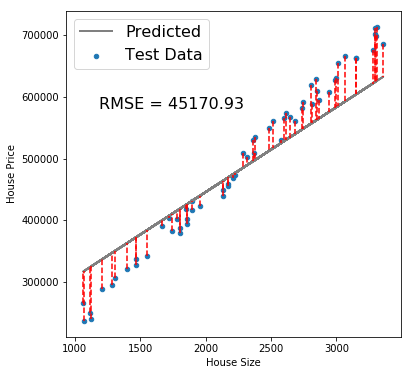

In [59]:
fig, ax = plt.subplots(1,1,figsize=(6,6))


# Predicted Model
ax.plot(data_housing_test.HouseSize, test_price_predicted, c='gray', lw=2, label = 'Predicted')
# Actual test data
ax.scatter(data_housing_test.HouseSize, data_housing_test.HousePrice, s = 20, label = 'Test Data')

mean_squared_error = 0
for price_point, size_point, price_pred in zip(data_housing_test.HousePrice, data_housing_test.HouseSize, test_price_predicted):
    ax.plot([size_point, size_point], [price_point, price_pred], c='r', lw=1.5, ls ='--')
    mean_squared_error += (price_point - price_pred)**2

mean_squared_error = mean_squared_error/len(data_housing_test)
rmse = np.sqrt(mean_squared_error)

ax.text(0.1,.7, 'RMSE = {:.2f}'.format(rmse), transform = ax.transAxes, fontsize=16)

ax.set_xlabel('House Size'); ax.set_ylabel('House Price')
ax.legend(fontsize = 16)

### Deep Learning

In [60]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Normalize data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Note: no need to transform the labels to one-hot format. Keras will do that for you

model = tf.keras.models.Sequential()

# Input layer for the firsrt layer the input shape is required
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

# Two hiddedn layer. Keras figures out the input shape based on the previous layer
model.add(tf.keras.layers.Dense(units = 128, activation=tf.nn.relu)) # Rectified linear
model.add(tf.keras.layers.Dense(units = 128, activation=tf.nn.relu)) 

# Output layer
model.add(tf.keras.layers.Dense(units = 10, activation=tf.nn.softmax)) # output layer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=100, validation_data=(x_test, y_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 29us/sample - loss: 0.3517 - acc: 0.9029 - val_loss: 0.1739 - val_acc: 0.9449
Epoch 2/4
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1448 - acc: 0.9563 - val_loss: 0.1254 - val_acc: 0.9622
Epoch 3/4
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0971 - acc: 0.9706 - val_loss: 0.1062 - val_acc: 0.9677
Epoch 4/4
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0721 - acc: 0.9774 - val_loss: 0.0935 - val_acc: 0.9717


#### Get the prediction

In [62]:
prediction = model.predict(x_test)

#### Visualize the predictions

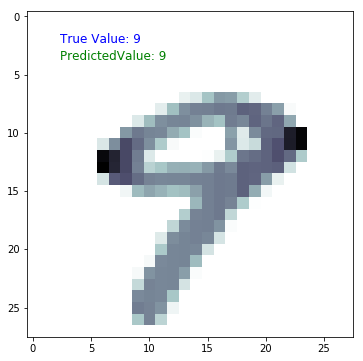

In [63]:
mnist_result_anim(x_test[0:10],y_test[0:10], prediction[0:10])

## Using TFLearn

TFLearn is an API that only works for TensorFlow and is a part of TensorFlow distribution.

In [ ]:
# import tflearn
# from tflearn.layers.core import input_data, dropout, fully_connected
# from tflearn.layers.conv import conv_2d, max_pool_2d
# from tflearn.layers.normalization import local_response_normalization
# from tflearn.layers.estimator import regression

In [ ]:
# mnist = tf.keras.datasets.mnist
# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
# y_train, y_test = transform_label(y_train), transform_label(y_test)

### Settings

In [ ]:
# image_nrows = 28
# image_ncolumns = 28
# image_flat_size = image_nrows*image_ncolumns
# n_channels = 1 # Gray scale
# n_classes = 10 # 0,1,... 9
# keep_prob = 0.6 # pul out neorons to avoid overfitting

In [ ]:
# image_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
# image_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

### Defining the network using TFLearn

In [ ]:
# # Define the input layer
# input_layer = input_data(shape=[None, image_nrows, image_ncolumns, 1], name='input')


# # Add the first convolutional layer
# network = conv_2d(input_layer, nb_filter=32, filter_size=3, activation='relu', regularizer="L2")
# #   Notice name was not specified.  The name is defaulted to "Conv2D", and will be postfixed with "_n" 

# # Implement pooling layer
# network = max_pool_2d(network, 2)

# # Add the second convolutional layer
# network = conv_2d(network, nb_filter=64, filter_size=3, activation='relu', regularizer="L2")
# # Implement pooling layer
# network = max_pool_2d(network, 2)

# # Add fully Connected Layer
# network = fully_connected(network, 128, activation='tanh')

# # dropout some neurons to reduce overfitting
# network = dropout(network, keep_prob)

# # Readout layer (based on one-hot)
# network = fully_connected(network, 10, activation='softmax')

# # Set loss and measurement, optimizer
# network = regression(network, optimizer='adam', learning_rate=0.01,
#                         loss='categorical_crossentropy', name='target')


### Train the network

In [ ]:
# num_epoch = 2  
# model = tflearn.DNN(network, tensorboard_verbose=0)  # for more info in tenorboard turn on tensorboard_verbose
# model.fit({'input': image_train}, {'target': y_train}, n_epoch=num_epoch,
#            validation_set=({'input': image_test}, {'target': y_test}),
#             show_metric=True, run_id='TFLearn_DeepMNIST')


In [ ]:
# prediction = model.predict(image_test)

In [ ]:
# mnist_result_anim(x_test,y_test, prediction)